In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
from config.loader import load_config
import torch
from sklearn.preprocessing import MinMaxScaler
import src.measurements.api as mpi
import numpy as np
import src.generator.api as gpi


In [46]:
dates = mpi.API().unique_dates()
measurement = mpi.API().measurement(dates=dates)


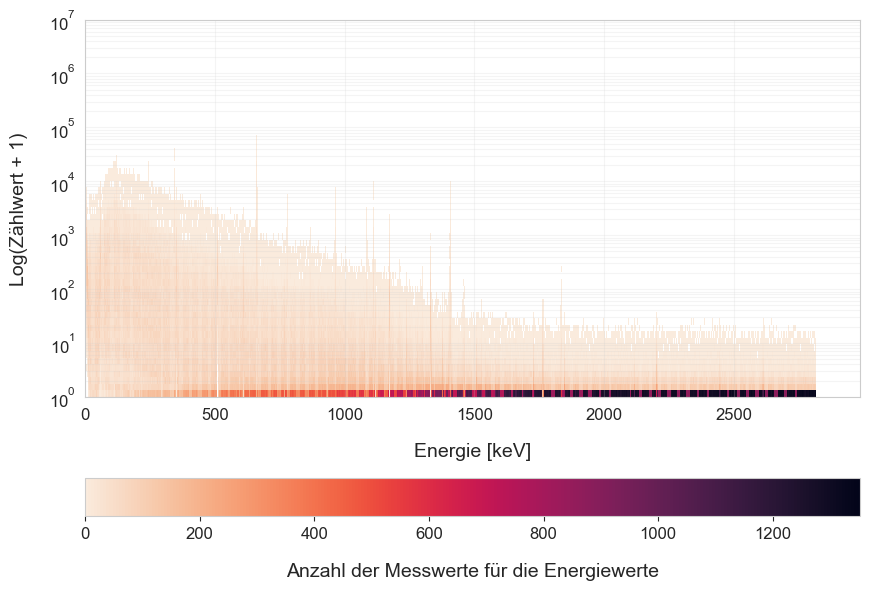

In [54]:

synthetic_keys = gpi.API().unique_keys()
synthetics = gpi.API().synthetics(keys=synthetic_keys)
plt.figure(figsize=(10, 7))
synthetics["count_shifted"] = synthetics["count"] + 1
ax = sns.histplot(
    synthetics,
    x="energy",
    y="count_shifted",
    bins=(2988, 40),
    log_scale=(False, True),
    cbar=True,
    cbar_kws={
        "orientation": "horizontal",
        "shrink": 1,
        "label": "Anzahl der Messwerte für die Energiewerte",
    },
    cmap=sns.color_palette("rocket_r", as_cmap=True),
    zorder=-10,
    # rasterized=True
)
cbar = ax.figure.axes[-1]
cbar.xaxis.label.set_size(14)
cbar.xaxis.labelpad = 15
cbar.tick_params(labelsize=12)
ax.set_rasterization_zorder(0)
plt.xlabel("Energie [keV]", size=14, labelpad=15)
plt.ylabel("Log(Zählwert + 1)", size=14, labelpad=15)
plt.xticks(size=12)
plt.yticks(size=12)
plt.ylim(1, 10000000)
plt.xlim(0, 2988)
plt.grid(alpha=0.2, which="both")
plt.savefig("plots\\count_energy_heatmap.svg", format="svg")
plt.show()
plt.close()

In [3]:
len(dates)  # Number of unique Measurements

1246

In [4]:
measurement.describe()

,datetime,energy,count
count,10167360,1.016736e+07,1.016736e+07
mean,2021-06-12 03:57:33.639648256,1.407263e+03,2.352156e+02
min,2016-11-21 09:27:54,-1.140000e+00,0.000000e+00
25%,2020-09-15 07:12:43,7.028000e+02,0.000000e+00
50%,2021-08-05 11:56:36.500000,1.406300e+03,1.000000e+00
75%,2022-11-11 06:45:42,2.109590e+03,6.000000e+00
max,2024-10-02 07:37:57,2.987800e+03,1.127511e+07
std,NaN,8.140717e+02,1.481372e+04


In [5]:
measurement.describe().apply(lambda s: s.apply("{0:.5f}".format))

,datetime,energy,count
count,10167360.00000,10167360.00000,10167360.00000
mean,.5f,1407.26332,235.21555
min,.5f,-1.14000,0.00000
25%,.5f,702.80000,0.00000
50%,.5f,1406.30000,1.00000
75%,.5f,2109.59000,6.00000
max,.5f,2987.80000,11275109.00000
std,nan,814.07168,14813.72115


In [6]:
measurement_diffs = (
    measurement.sort_values(by="energy").groupby("datetime").diff().dropna()
)
measurement_diffs["energy"] = measurement_diffs["energy"].round(2)
measurement_diffs = measurement_diffs.join(
    measurement, lsuffix="_diffs", rsuffix="_raw", how="left"
)
diffs = measurement_diffs.groupby("energy_diffs").count().reset_index()
diffs["percent"] = diffs["count_diffs"] / diffs["count_diffs"].sum() * 100

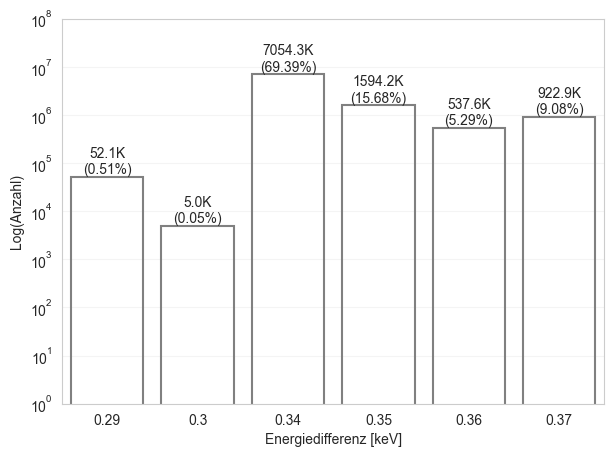

In [7]:
"""
Plotting the differences of the energies, to analyse the x-axis for every measurement.
"""
plt.rcParams["svg.fonttype"] = "none"
fig = plt.figure(figsize=(7, 5))
ax = sns.barplot(
    diffs,
    x="energy_diffs",
    y="count_diffs",
    color="grey",
    linewidth=1.5,
    edgecolor=".5",
    facecolor=(0, 0, 0, 0),
)
labels = [
    f"{c / 1e3:.1f}K\n({p:.2f}%)"
    for c, p in zip(diffs["count_diffs"], diffs["percent"])
]
ax.bar_label(ax.containers[0], labels=labels, fontsize=10)
# plt.title("Untersuchung der Energiewerte")
plt.xlabel("Energiedifferenz [keV]")
plt.ylabel("Log(Anzahl)")
plt.grid(axis="y", alpha=0.2)
plt.yscale("log")
plt.ylim(1, 100000000)
plt.savefig("plots\\energy_diffs.svg")
plt.show()
plt.close()

In [48]:
measurement = measurement.sort_values(by="count")
measurement["count_shifted"] = measurement["count"] + 1
counts = measurement["count"].to_numpy() + 1
print(counts)

# log_counts = np.log(counts)
# sigma = np.std(log_counts)
# mu = np.mean(log_counts)
#
x = np.linspace(min(counts), max(counts), 10000000)
# pdf = np.exp(-((np.log(x) - mu) ** 2) / (2 * sigma ** 2)) / (
#         x * sigma * np.sqrt(2 * np.pi)
# )

[       1        1        1 ... 10160756 10512824 11275110]


0.8143124825254802 0 1


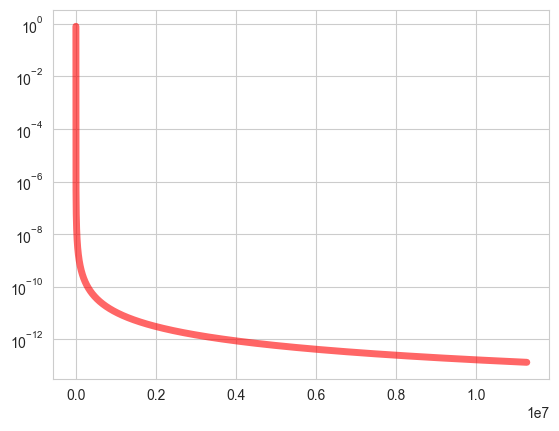

In [9]:
from scipy.stats import pareto
import torch.distributions as dis

# dis.Pareto(counts)
# dis.kl_divergence()


b, loc, scale = pareto.fit(counts, floc=0)
print(b, loc ,scale)
plt.plot(x, pareto.pdf(x, b),
       'r-', lw=5, alpha=0.6, label='pareto pdf')
plt.yscale("log")


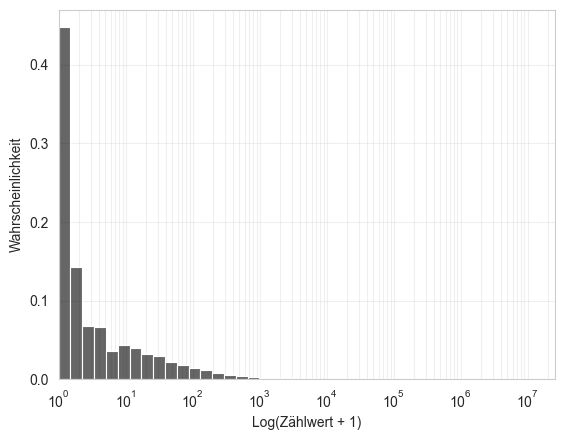

In [49]:
sns.histplot(
    counts,
    bins=40,
    stat="probability",
    color="black",
    alpha=0.6,
    label="Data",
    log_scale=(True, False),
)
plt.xlabel("Log(Zählwert + 1)")
plt.ylabel("Wahrscheinlichkeit")
plt.grid(True, alpha=0.3, which="both")
plt.xlim(
    1,
)
plt.savefig("plots\\count_histogram.svg")
plt.show()
plt.close()

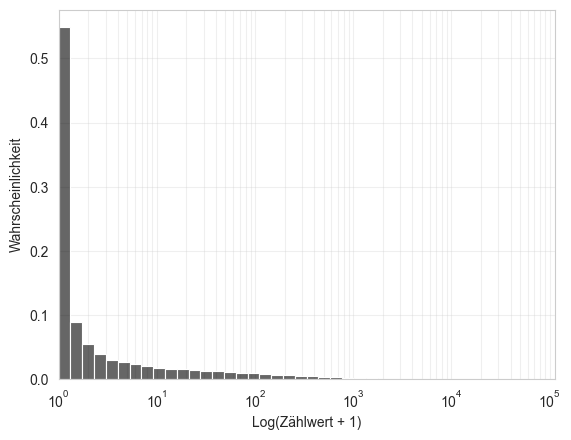

In [51]:
synthetic_keys = gpi.API().unique_keys()
synthetics = gpi.API().synthetics(keys=synthetic_keys)
counts = synthetics["count"].to_numpy() + 1

sns.histplot(
    counts,
    bins=40,
    stat="probability",
    color="black",
    alpha=0.6,
    label="Data",
    log_scale=(True, False),
)
plt.xlabel("Log(Zählwert + 1)")
plt.ylabel("Wahrscheinlichkeit")
plt.grid(True, alpha=0.3, which="both")
plt.xlim(
    1,
)
plt.savefig("plots\\count_histogram.svg")
plt.show()
plt.close()

In [11]:
dx = x[1] - x[0]  # step size
cdf = np.cumsum(pdf) * dx
cdf /= cdf[-1]

fig, axs = plt.subplots(1, 2, figsize=(7, 5))

axs[0].plot(x, pdf, color="black", linewidth=2)
axs[0].set_xscale("log")
axs[0].set_xlabel("Log(Zählwert + 1)")
axs[0].set_ylabel("PDF")
axs[0].grid(True, alpha=0.5, which="both")
axs[0].set_title("Probability Density\nFunction (PDF)")

axs[1].plot(x, cdf, color="black")
axs[1].set_xscale("log")
axs[1].set_xlabel("Log(Zählwert + 1)")
axs[1].set_ylabel("CDF")
axs[1].grid(True, alpha=0.5, which="both")
axs[1].set_title("Cumulative Distribution\nFunction (CDF)")

fig.tight_layout()
plt.savefig("plots\\count_cdf.svg")
plt.show()
plt.close()

NameError: name 'pdf' is not defined

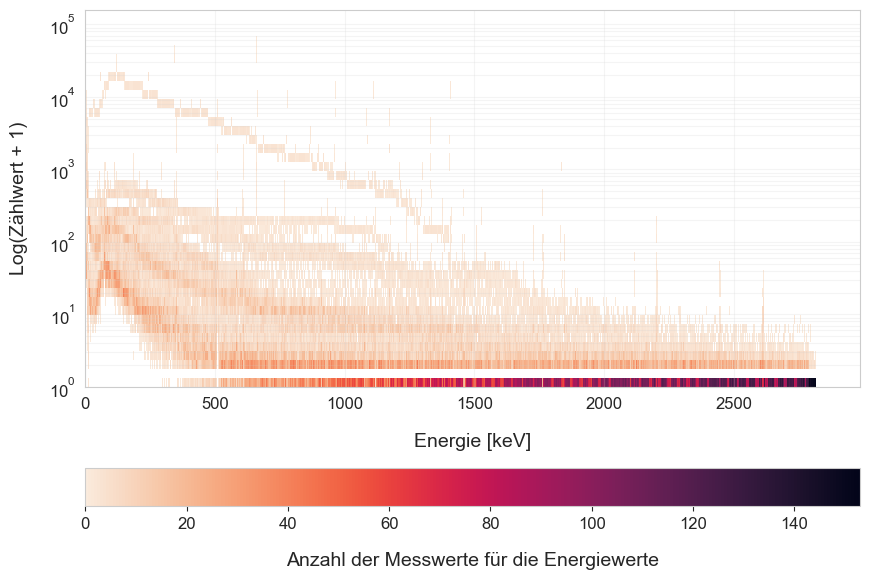

In [57]:
import src.peaks.api as ppi

ppi_dates = ppi.API().unique_dates()
ppi_measurements = ppi.API().measurement(ppi_dates)


plt.figure(figsize=(10, 7))
ppi_measurements["count_shifted"] = ppi_measurements["count"] + 1
ax = sns.histplot(
    ppi_measurements,
    x="energy",
    y="count_shifted",
    bins=(2988, 40),
    log_scale=(False, True),
    cbar=True,
    cbar_kws={
        "orientation": "horizontal",
        "shrink": 1,
        "label": "Anzahl der Messwerte für die Energiewerte",
    },
    cmap=sns.color_palette("rocket_r", as_cmap=True),
    zorder=-10,
    # rasterized=True
)
cbar = ax.figure.axes[-1]
cbar.xaxis.label.set_size(14)
cbar.xaxis.labelpad = 15
cbar.tick_params(labelsize=12)
ax.set_rasterization_zorder(0)
plt.xlabel("Energie [keV]", size=14, labelpad=15)
plt.ylabel("Log(Zählwert + 1)", size=14, labelpad=15)
plt.xticks(size=12)
plt.yticks(size=12)
plt.ylim(1)
plt.xlim(0, 2988)
plt.grid(alpha=0.2, which="both")
plt.savefig("plots\\count_energy_heatmap.svg", format="svg")
plt.show()
plt.close()

In [109]:
synthetic_keys = gpi.API().unique_keys()
synthetics = gpi.API().synthetics(keys=synthetic_keys[0:185])
dates = mpi.API().unique_dates()
processed_measurement = mpi.API().measurement(dates[0:200])

print(len(processed_measurement), len(synthetics))

1632000 1632000


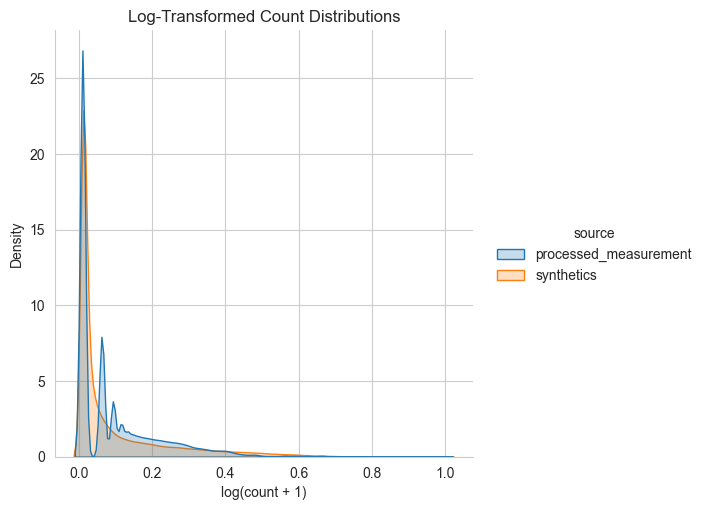

KstestResult(statistic=np.float64(0.47385539215686273), pvalue=np.float64(0.0), statistic_location=np.float64(0.01), statistic_sign=np.int8(1))
[773333      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0 230796      0      0      0      0      0      0      0      0
      0      0      0 105700      0      0      0      0      0      0
      0      0  60819      0      0      0      0      0      0  40767
      0      0      0      0  30496      0      0      0      0  24570
      0      0      0  20350      0      0      0  17491      0      0
  15279      0      0  13656      0      0  12151      0  10863      0
   9823      0      0   9242      0   8576   7735      0   7290      0
   6763   6227      0   6015   5534      0   5258   5049   4605   4635
      0   4285   4151   3978   3850   3567   3541   3261   3122   6123
   2775   2754   2656   4775   2221   2293   4168   1967   3617   3341
   1

C:\Users\VID\Desktop\GitHub\nuclide-identification\.venv\Lib\site-packages\scipy\stats\_stats_py.py:7654: RuntimeWarning: divide by zero encountered in divide
  terms = (f_obs - f_exp)**2 / f_exp
C:\Users\VID\Desktop\GitHub\nuclide-identification\.venv\Lib\site-packages\scipy\stats\_stats_py.py:7654: RuntimeWarning: invalid value encountered in divide
  terms = (f_obs - f_exp)**2 / f_exp


In [139]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Log-transform the counts
sample1 = np.log(processed_measurement["count"].to_numpy() + 1).reshape(-1, 1)
sample2 = np.log(synthetics["count"].to_numpy() + 1).reshape(-1, 1)

# Min-Max-Skalierung auf [0,1]
scaler1 = MinMaxScaler(feature_range=(0.01, 1.0))  # min nicht 0, da Pareto >0 sein muss
scaler2 = MinMaxScaler(feature_range=(0.01, 1.0))

sample1_scaled = scaler1.fit_transform(sample1).flatten()
sample2_scaled = scaler2.fit_transform(sample2).flatten()

# Combine into a DataFrame
df = pd.DataFrame({
    "log_count": np.concatenate([sample1_scaled, sample2_scaled]),
    "source": ["processed_measurement"] * len(sample1_scaled) + ["synthetics"] * len(sample2_scaled)
})

# Plot with seaborn
sns.displot(df, x="log_count", hue="source", kind="kde", fill=True, common_norm=False)
plt.title("Log-Transformed Count Distributions")
plt.xlabel("log(count + 1)")
plt.ylabel("Density")
plt.show()

import numpy as np
from scipy import stats
print(stats.ks_2samp(sample1_scaled, sample2_scaled))

from scipy.stats import chisquare

# Histogram (same bins)
counts1, bins = np.histogram(sample1_scaled, bins=400)
counts2, _ = np.histogram(sample2_scaled, bins=bins)

print(counts1, counts2)

# Chi-squared test
chi2_stat, p_value = chisquare(counts1, f_exp=counts2)
print(chi2_stat)
print(p_value)



In [140]:
from scipy.stats import pareto
import numpy as np
# Fit Pareto to data1 and data2
params1 = pareto.fit(sample1_scaled, floc=0)
print(min(sample1_scaled), max(sample1_scaled))
params2 = pareto.fit(sample2_scaled, floc=0)
print(min(sample2_scaled), max(sample2_scaled))

print(f"Sample 1 Pareto params: shape={params1[0]:.3f}, loc={params1[1]:.3f}, scale={params1[2]:.3f}")
print(f"Sample 2 Pareto params: shape={params2[0]:.3f}, loc={params2[1]:.3f}, scale={params2[2]:.3f}")

0.01 1.0
0.01 1.0
Sample 1 Pareto params: shape=0.718, loc=0.000, scale=0.010
Sample 2 Pareto params: shape=0.734, loc=0.000, scale=0.010


KstestResult(statistic=np.float64(0.03), pvalue=np.float64(0.7593695685682871), statistic_location=np.float64(0.026301992518168824), statistic_sign=np.int8(-1))


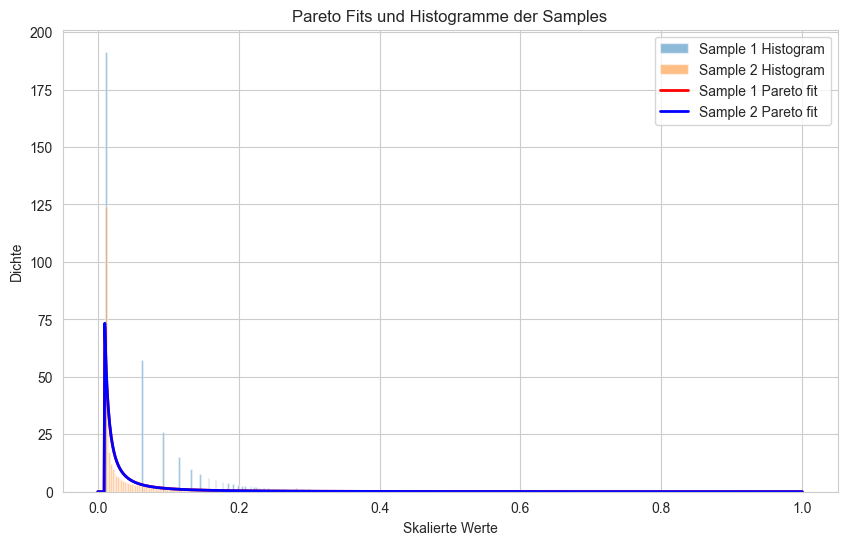

In [142]:
# x-Achse für den Plot: Werte von minimalem bis maximalem Wert aller Samples
x = np.linspace(0, max(np.max(sample1_scaled), np.max(sample2_scaled)), 1000)

# PDF der gefitteten Pareto-Verteilungen berechnen
pdf1 = pareto.pdf(x, *params1)
pdf2 = pareto.pdf(x, *params2)

print(stats.ks_2samp(pdf1, pdf2))

plt.figure(figsize=(10,6))
plt.hist(sample1_scaled, bins=400, density=True, alpha=0.5, label="Sample 1 Histogram")
plt.hist(sample2_scaled, bins=400, density=True, alpha=0.5, label="Sample 2 Histogram")
plt.plot(x, pdf1, 'r-', lw=2, label='Sample 1 Pareto fit')
plt.plot(x, pdf2, 'b-', lw=2, label='Sample 2 Pareto fit')
plt.title("Pareto Fits und Histogramme der Samples")
plt.xlabel("Skalierte Werte")
plt.ylabel("Dichte")
plt.legend()
plt.show()

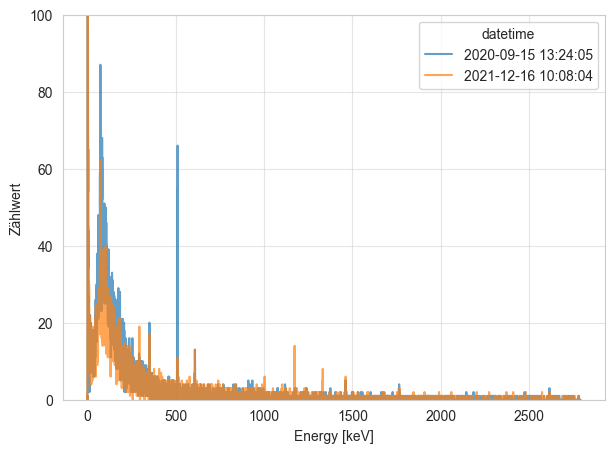

In [58]:
one_measurement = measurement.loc[measurement["datetime"].isin(dates[6:8])]

plt.figure(figsize=(7, 5))
sns.lineplot(one_measurement, x="energy", y="count", hue="datetime", alpha=0.7)

plt.ylim(0, 100)
plt.xlabel("Energy [keV]")
plt.ylabel("Zählwert")
plt.grid(alpha=0.5)
plt.savefig("plots\\measurement_example.svg")
plt.show()
plt.close()

In [16]:
measurement_diffs.describe().apply(lambda s: s.apply("{0:.5f}".format))

,energy_diffs,count_diffs,datetime,energy_raw,count_raw
count,10166114.00000,10166114.00000,10166114.00000,10166114.00000,10166114.00000
mean,0.34507,0.00082,.5f,1407.43586,235.24397
min,0.29000,-2399460.00000,.5f,-0.78000,0.00000
25%,0.34000,-1.00000,.5f,703.15000,0.00000
50%,0.34000,0.00000,.5f,1406.30000,1.00000
75%,0.35000,1.00000,.5f,2109.80000,6.00000
max,0.37000,2667689.00000,.5f,2987.80000,11275109.00000
std,0.01032,2276.21540,nan,813.97237,14814.62871


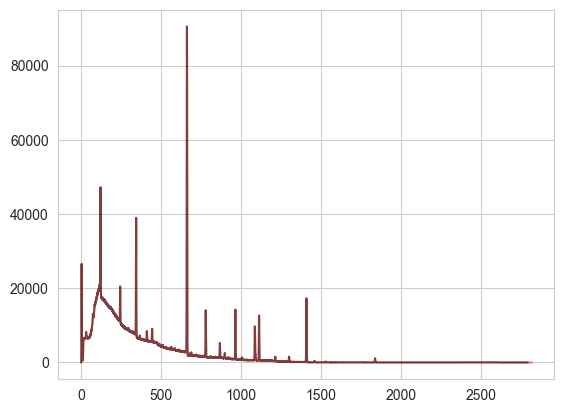

0.34507313512321336


In [18]:
import numpy as np
from scipy.interpolate import interp1d

def interpolate_spectrum(energy_original, counts_original, energy_target):
    f = interp1d(
        energy_original,
        counts_original,
        kind="nearest",
        bounds_error=False,
        fill_value=0,
    )
    return f(energy_target)


step_size = measurement_diffs["energy_diffs"].mean()
energy_max = step_size * 8160
# etwas über 2987.8, MAX VALUE OF diffs
energy_axis = np.arange(0, energy_max, step_size)
test_energy = measurement.loc[measurement["datetime"] == dates[0]].sort_values(
    by="energy"
)
interpolated_counts = interpolate_spectrum(
    test_energy["energy"].values, test_energy["count"].values, energy_axis
)

test_energy["energy_axis"] = energy_axis
test_energy["interpolated_counts"] = interpolated_counts

plt.plot(energy_axis, interpolated_counts, color="red", alpha=0.5)
plt.plot(test_energy["energy"], test_energy["count"], alpha=0.5, color="black")
# plt.xlim(0, 10)
plt.show()

print(step_size)

In [20]:
generated_x_hat = []

for i in range(5):
    z = torch.from_numpy(np.arange(-1, 1, 1 / 12, dtype="float32")).to(Hyperparameter.DEVICE)
    z[0] = 0.0 + i / 1
    mlflow.set_tracking_uri(uri=load_config()["mlflow"]["uri"])
    model = mlflow.pytorch.load_model("runs:/278c374f3b39436e9648039d00374309/model")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    x_hat = model.decode(z).to("cpu").detach().numpy()
    generated_x_hat.append(x_hat)



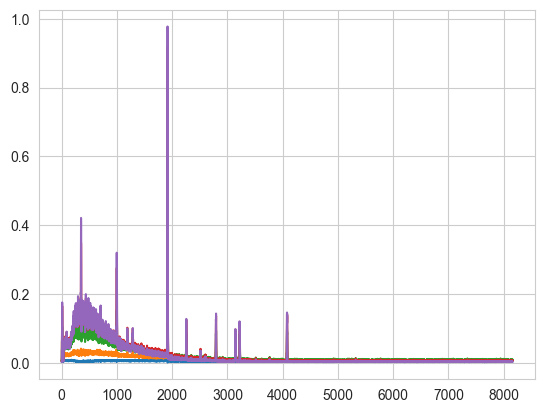

In [21]:
for i in generated_x_hat:
    plt.plot(i)


         count       energy     datetime
0     0.005710     0.000000  synthetic_1
1     0.004688     0.345073  synthetic_1
2     0.005703     0.690146  synthetic_1
3     0.008156     1.035219  synthetic_1
4     0.008083     1.380293  synthetic_1
...        ...          ...          ...
8155  0.006915  2814.071417  synthetic_1
8156  0.005344  2814.416490  synthetic_1
8157  0.006676  2814.761563  synthetic_1
8158  0.007913  2815.106636  synthetic_1
8159  0.008178  2815.451709  synthetic_1

[8160 rows x 3 columns]


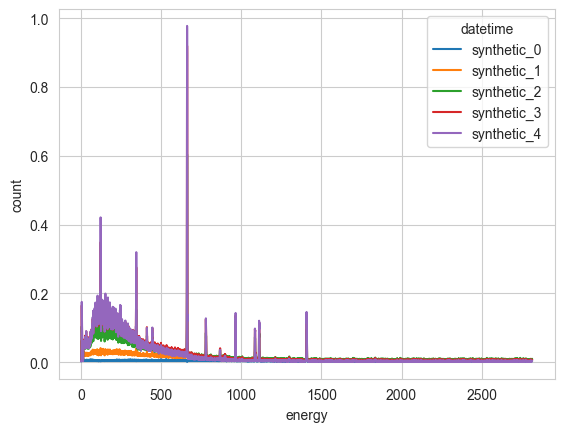

In [22]:
import pandas as pd

step_size = 0.34507313512321336
energy_max = step_size * 8160
energy_axis = np.arange(0, energy_max, step_size)

data = pd.DataFrame([])
for idx, i in enumerate(generated_x_hat):
    synthetic_data = pd.DataFrame(i)
    synthetic_data["energy"] = energy_axis
    synthetic_data["datetime"] = f"synthetic_{idx}"
    data = pd.concat([data, synthetic_data])
data = data.rename(columns={0: "count"})
sns.lineplot(data=data, x="energy", y="count", hue="datetime")

print(data.loc[data["datetime"] == "synthetic_1"].reset_index(drop=True))

In [23]:
from src.peaks.finder import PeakFinder
data = data.loc[data["datetime"] == "synthetic_4"].reset_index(drop=True)
result = PeakFinder(
    selected_date="synthetic_4",
    data=data,
    meta=None,
    schema="processed_synthetics",
    nuclides=[
        "cs137",
        "co60",
        "i131",
        "tc99m",
        "ra226",
        "th232",
        "u238",
        "k40",
        "am241",
        "na22",
        "eu152",
        "eu154",
    ],
    tolerance=0.00,
    nuclides_intensity=10,
    matching_ratio=0,
    interpolate_energy=False,
).process_spectrum(return_detailed_view=False)
print(sum(result["peak"]))

0


In [29]:
def __polynomial_f(a,b,c,d):
    return (
        lambda x: a
                  + b * x
                  + c * x ** 2
                  + d * x ** 3
    )
#self.polynomial(np.array([11.404]))
#array([3.54503517]) FÜR

data = mpi.API().measurement(["2019-01-11 14:21:21"]).sort_values(by="energy")
print(data)
x = data["energy"].to_numpy()
y = data["count"].to_numpy()
y_scaled = MinMaxScaler().fit_transform(y.reshape(-1, 1)).reshape(-1)

coef = np.polyfit(np.arange(0, 8160, 1), x, deg=3)

polynom = __polynomial_f(coef[-1], coef[-2], coef[-3], coef[-4])
print(polynom)
print(coef)
print(polynom(np.array([11.404])))

# p = Polynomial(np.array([-0.4355, 0.290407, 561753e-8]))
# plt.plot(np.arange(0, 8160, 1), polynom(y), color="red")
# plt.plot(y)
# plt.yscale("log")
# plt.ylim(0,1000000)


                datetime   energy  count
0    2019-01-11 14:21:21    -0.35      1
1    2019-01-11 14:21:21    -0.01      3
2    2019-01-11 14:21:21     0.33      9
3    2019-01-11 14:21:21     0.67     24
4    2019-01-11 14:21:21     1.01     54
...                  ...      ...    ...
8155 2019-01-11 14:21:21  2787.33      2
8156 2019-01-11 14:21:21  2787.67      0
8157 2019-01-11 14:21:21  2788.01      2
8158 2019-01-11 14:21:21  2788.35      5
8159 2019-01-11 14:21:21  2788.69      2

[8160 rows x 3 columns]
<function __polynomial_f.<locals>.<lambda> at 0x0000019D4A023B00>
[-1.34424107e-16  2.08398967e-12  3.41836725e-01 -3.53254240e-01]
[3.54505178]


In [38]:
import mlflow
from config.loader import load_config
mlflow.set_tracking_uri(uri=load_config()["mlflow"]["uri"])
model = mlflow.pytorch.load_model("runs:/e0f5749e6e9b4e01998372e453525a60/model")
client = mlflow.tracking.MlflowClient(tracking_uri=load_config()["mlflow"]["uri"])
run = client.get_run("e0f5749e6e9b4e01998372e453525a60")

RestException: RESOURCE_DOES_NOT_EXIST: Run with id=e0f5749e6e9b4e01998372e453525a60 not found

In [37]:
run.data

NameError: name 'run' is not defined

In [72]:
losses =  client.get_metric_history("e0f5749e6e9b4e01998372e453525a60", "training_loss")

In [73]:
import pandas as pd
df = pd.DataFrame([{"step": m.step, "value": m.value, "timestamp": m.timestamp} for m in losses])

    step        value      timestamp
0      0  1585.116653  1746737910120
1      0   741.866104  1746737910137
2      0   339.897635  1746737910155
3      0   156.446219  1746737910176
4      0   114.572634  1746737910214
..   ...          ...            ...
95     0     2.131013  1746737912539
96     0     3.509812  1746737912556
97     0     2.208054  1746737912572
98     0     2.435406  1746737912599
99     0     3.029640  1746737912615

[100 rows x 3 columns]


AttributeError: 'Axes' object has no attribute 'reset_index'

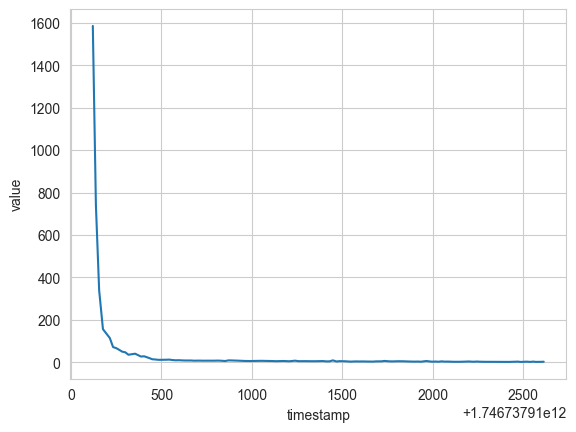

In [74]:
import seaborn as sns
print(df)
sns.lineplot(data=df, x="timestamp", y="value").reset_index()

In [88]:
logged_dataset = run.inputs.dataset_inputs[0].dataset
print(logged_dataset)
dataset_source = mlflow.data.get_source(logged_dataset)
dataset_source

<Dataset: digest='59ccafba', name='dataset', profile='{"num_rows": 81600, "num_elements": 897600}', schema=('{"mlflow_colspec": [{"type": "datetime", "name": "datetime", "required": '
 'true}, {"type": "double", "name": "energy", "required": true}, {"type": '
 '"double", "name": "count", "required": true}, {"type": "double", "name": '
 '"background", "required": true}, {"type": "boolean", "name": "peak", '
 '"required": true}, {"type": "boolean", "name": "interpolated", "required": '
 'true}, {"type": "double", "name": "total_confidence", "required": true}, '
 '{"type": "double", "name": "matched", "required": true}, {"type": "double", '
 '"name": "confidence", "required": true}, {"type": "double", "name": '
 '"identified_peak", "required": true}, {"type": "string", "name": '
 '"identified_isotope", "required": true}]}'), source=('{"tags": {"mlflow.user": "VID", "mlflow.source.name": '
 '"C:\\\\Users\\\\VID\\\\Desktop\\\\GitHub\\\\nuclide-identification\\\\example_vae_process.py", '
 '

In [96]:
logged_run = client.get_run("e0f5749e6e9b4e01998372e453525a60")
logged_dataset = logged_run.inputs.dataset_inputs[0].dataset

In [102]:
mlflow.data.get_source(logged_dataset).load()

NotImplementedError: 

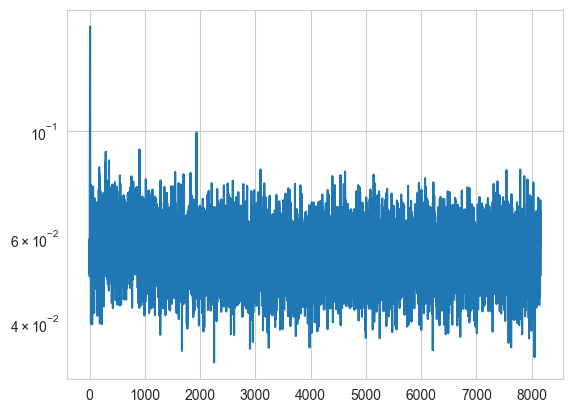

In [40]:
import mlflow
from config.loader import load_config
import torch
import numpy as np
import matplotlib.pyplot as plt
from src.generator.generator import Generator

generator = Generator().generate(latent_space=[np.arange(-1, 1, 1 / 24, dtype="float32")])

model_name = "VAE"
model_version = "latest"
model_uri = load_config()["mlflow"]["uri"]
device = load_config()["vae"]["device"]
latent_dim = load_config()["vae"]["latent_dim"] / 2
mlflow.set_tracking_uri(uri=model_uri)
model = mlflow.pytorch.load_model(f"models:/{model_name}/{model_version}")

generated_x_hat = []

for i in generator:
    plt.plot(i)
    plt.yscale("log")



In [6]:
import mlflow
from config.loader import load_config
import os

os.environ["AWS_ACCESS_KEY_ID"] = load_config()["minio"]["AWS_ACCESS_KEY_ID"]
os.environ["AWS_SECRET_ACCESS_KEY"] = load_config()["minio"]["AWS_SECRET_ACCESS_KEY"]
os.environ["MLFLOW_S3_ENDPOINT_URL"] = load_config()["minio"]["MLFLOW_S3_ENDPOINT_URL"]
model_name = "VAE_CPU"
model_version = "latest"
mlflow.set_tracking_uri(uri=load_config()["mlflow"]["uri"])


    step       value      timestamp
0      0  369.323608  1746977405601
1      0   38.316107  1746977405623
2      0   20.194182  1746977405637
3      0    8.707803  1746977405650
4      0    5.008083  1746977405668
..   ...         ...            ...
95     0    0.514473  1746977406931
96     0    0.507946  1746977406940
97     0    0.508553  1746977406951
98     0    0.515017  1746977406962
99     0    0.513209  1746977406972

[100 rows x 3 columns]


C:\Users\VID\AppData\Local\Temp\ipykernel_10056\3609264732.py:4: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  run_id = client.get_latest_versions("VAE_CPU")[0].run_id


<Axes: xlabel='timestamp', ylabel='value'>

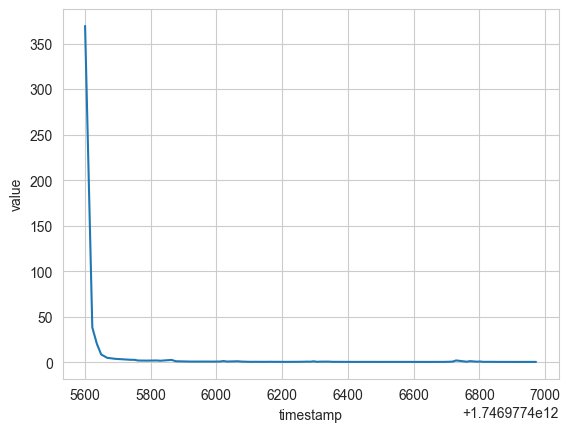

In [57]:
import pandas as pd
import seaborn as sns
client = mlflow.tracking.MlflowClient(tracking_uri=load_config()["mlflow"]["uri"])
run_id = client.get_latest_versions("VAE_CPU")[0].run_id
run = client.get_run(run_id)
losses=client.get_metric_history(run_id, "training_loss")
losses = pd.DataFrame([{"step": m.step, "value": m.value, "timestamp": m.timestamp} for m in losses])
sns.lineplot(losses, x="timestamp", y="value")

In [60]:
min = float(run.data.params["min"])
max = float(run.data.params["max"])
rescale =


90565.0